<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
krytpon DST notebook</p><br>

# Describes the preparation of the krypton DST based on FLEX MC data

In [1]:
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from   dataclasses import dataclass

In [2]:
from nextflex.core import Setup
from nextflex.core import PosQ

In [3]:
from nextflex.core import get_evt_true_positions_and_energy
from nextflex.core import get_evt_true_positions_df
from nextflex.core import get_sensor_response
from nextflex.core import sensor_response_ti
from nextflex.core import event_sensor_response_ti
from nextflex.core import sensor_number_response_ti

In [4]:
from nextflex.core import mcparts_and_sensors_response
from nextflex.core import get_s1
from nextflex.core import get_s2
from nextflex.core import get_qtot

In [260]:
from nextflex.core import get_q
from nextflex.core import get_pos
from nextflex.core import get_position
from nextflex.core import diff_pos

In [275]:
from nextflex.krypton_dst import kr_dst

In [92]:
from nextflex.krypton_analysis import histo_df
from nextflex.krypton_analysis import histos_df
from nextflex.krypton_analysis import histo1d
from nextflex.krypton_analysis import histos1d

In [7]:
import invisible_cities.core.system_of_units  as units
from invisible_cities.core.core_functions     import in_range

from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## DataFrames and SiPM map

### Data
- Data used in the tests are:
 - file **FLEX100_M6_O6.Kr83.ACTIVE.1000.next.h5** which contains 100 krypton events. The tracking plane is located at 15 mm from the anode and masks 6cm height and 6cm hole are used. SiPMs are Hamamatsu (1.3 x 1.3 mm2). The energy sensors are PMTs, whose response include QE. Instead, the response of the SiPM does not include PDE or the effect of membranes. 

 - file **NEXT_FLEX_Fibres_M6_06.Kr83.ACTIVE.1.next.h5** which contains 100 krypton events. The tracking plane is located at 15 mm from the anode and masks 6cm height and 6cm hole are used. SiPMs are Hamamatsu (1.3 x 1.3 mm2). The energy sensors are Fibres, whose response do not include QE. The response of the SiPM does not include PDE or the effect of membranes.
 
 - file **sipm_map.csv** which, for each SiPM contains the position and id of the sensor, and the positions and ids of sensors left, right, up and down (l,r,u,d) of the sensor


In [9]:
FDATA = os.environ['FLEXDATA']

In [16]:
testFile      = os.path.join(FDATA,"testData",
                            'FLEX100_M6_O6.Kr83.ACTIVE.1000.next.h5')
testFile2 = os.path.join(FDATA,"testData",
                                'NEXT_FLEX_Fibres_M6_06.Kr83.ACTIVE.1.next.h5')
mapFile       = os.path.join(FDATA,"testData", 'sipm_map.csv')

In [18]:
sipm_map      = pd.read_csv(mapFile)

In [19]:
sipm_map.head()

,Unnamed: 0,sensor_id,sensor_name,x,y,xl,xr,yu,yd,id_xl,id_xr,id_yu,id_yd
0,0,1040,TP_SiPM,15.55,-450.95,1.907349e-07,31.100000,-435.400012,-466.500012,1039,1041,1066,1019
1,1,4059,TP_SiPM,93.30,450.95,7.775000e+01,108.850003,466.500012,435.400012,4058,4060,4080,4033
2,2,3753,TP_SiPM,-62.20,326.55,-7.775000e+01,-46.650001,342.099988,310.999988,3752,3754,3799,3705
3,3,3842,TP_SiPM,-77.75,357.65,-9.330000e+01,-62.200000,373.199994,342.099994,3841,3843,3884,3798
4,4,3797,TP_SiPM,-93.30,342.10,-1.088500e+02,-77.750003,357.650006,326.550006,3796,3798,3841,3751


### Data Frames
- **mcParts** which describes the position, momentum, etc. of all the MC particles in the event
- **sns_response_pmt (fib)** which describe the charge and time for each sensor in the event

In [20]:
mcParts           = load_mcparticles_df(testFile)
sns_response_pmt  = load_mcsensor_response_df(testFile)
sns_response_fib  = load_mcsensor_response_df(testFile2)

In [21]:
mcParts.head()

particle_name  primary  mother_id   initial_x  \
event_id particle_id                                                 
100000   2                      e-     True          0  411.851990   
         1                      e-     True          0  411.851990   
100001   2                      e-     True          0 -450.390076   
         1                      e-     True          0 -450.390076   
100002   2                      e-     True          0  178.940918   

                       initial_y   initial_z  initial_t     final_x  \
event_id particle_id                                                  
100000   2            -83.967979  981.268127        0.0  411.860229   
         1            -83.967979  981.268127        0.0  411.961487   
100001   2            -20.009449  848.892822        0.0 -450.372742   
         1            -20.009449  848.892822        0.0 -450.387573   
100002   2           -268.440735  295.103363        0.0  178.936234   

                         final_y     final_z  ...  initial_momentum_x  \
event_id particle_id                          ...                       
100000   2            -83.969376  981.265015  ...            0.024411   
         1            -84.069504  981.291992  ...           -0.111088   
100001   2            -19.999857  848.884277  ...            0.061492   
         1            -19.987989  848.998352  ...            0.032593   
100002   2           -268.445679  295.094177  ...           -0.088341   

                     initial_momentum_y initial_momentum_z  final_momentum_x  \
event_id particle_id                                                           
100000   2                     0.014236           0.094300               0.0   
         1                    -0.118718           0.086334              -0.0   
100001   2                     0.060949          -0.046850               0.0   
         1                     0.113901           0.140898               0.0   
100002   2                    -0.030742          -0.030689              -0.0   

                      final_momentum_y  final_momentum_z  kin_energy  \
event_id particle_id                                                   
100000   2                         0.0              -0.0    0.009396   
         1                        -0.0               0.0    0.032147   
100001   2                         0.0               0.0    0.009396   
         1                        -0.0              -0.0    0.032147   
100002   2                         0.0               0.0    0.009396   

                        length  creator_proc     final_proc  
event_id particle_id                                         
100000   2            0.062259          none  Scintillation  
         1            0.456158          none  Scintillation  
100001   2            0.066419          none  Scintillation  
         1            0.569584          none  Scintillation  
100002   2            0.076495          none  Scintillation  

[5 rows x 23 columns]

In [24]:
print(mcParts.columns)

Index(['particle_name', 'primary', 'mother_id', 'initial_x', 'initial_y',
       'initial_z', 'initial_t', 'final_x', 'final_y', 'final_z', 'final_t',
       'initial_volume', 'final_volume', 'initial_momentum_x',
       'initial_momentum_y', 'initial_momentum_z', 'final_momentum_x',
       'final_momentum_y', 'final_momentum_z', 'kin_energy', 'length',
       'creator_proc', 'final_proc'],
      dtype='object')


In [22]:
sns_response_pmt.head()

charge      time
event_id sensor_id                  
100000   35              2  979100.0
         35              1  979175.0
         35              1  979275.0
         35              1  979400.0
         35              1  979525.0

In [23]:
sns_response_fib.head()

charge       time
event_id sensor_id                   
100      100662          2  1005000.0
         100662          1  1007000.0
         100662          3  1008000.0
         100662          5  1009000.0
         100662          1  1010000.0

## kr_dst components (in core.py)

### Setup

***
@dataclass\
class Setup:

    name              : str   = 'NEXT100_PMTs_sipmPDE_1_maskPDE_1_qTh_0'
    sipmPDE           : float = 1.0
    maskPDE           : float = 1.0
    qTh               : float = 0.0
    maskConfig        : str   = "FLEX100_M6_O6" # means thickness 6 mm hole 6mm
    mapDIR            : str   = "flexmaps" # where to find the SiPM map
    fibres            : bool  = False

***


In [25]:
setup = Setup()

In [26]:
setup

Setup(name='NEXT100_PMTs_sipmPDE_1_maskPDE_1_qTh_0', sipmPDE=1.0, maskPDE=1.0, qTh=0.0, maskConfig='FLEX100_M6_O6', mapDIR='flexmaps', fibres=False)

In [29]:
def test_Setup():
    setup = Setup()
    c1 = setup.name              == 'NEXT100_PMTs_sipmPDE_1_maskPDE_1_qTh_0'
    c2 = setup.sipmPDE           == 1.0
    c3 = setup.maskPDE           == 1.0
    c4 = setup.qTh               == 0.0
    c5 = setup.maskConfig        == "FLEX100_M6_O6"
    c6 = setup.mapDIR            == "flexmaps"
    c7 = setup.fibres            == False
    return c1 and c2 and c3 and c4 and c5 and c6 and c7

In [30]:
test_Setup()

True

### Functions that manipulate true information

***
def get_evt_true_positions_df(mcParts : DataFrame)->DataFrame:

In [31]:
evt_truePos = get_evt_true_positions_df(mcParts)
evt_truePos.head()

,true_x,true_y,true_z
event_id,,,
100000,411.851990,-83.967979,981.268127
100001,-450.390076,-20.009449,848.892822
100002,178.940918,-268.440735,295.103363
100003,-36.024593,-41.193062,367.160645
100004,176.177246,-167.092148,245.398712


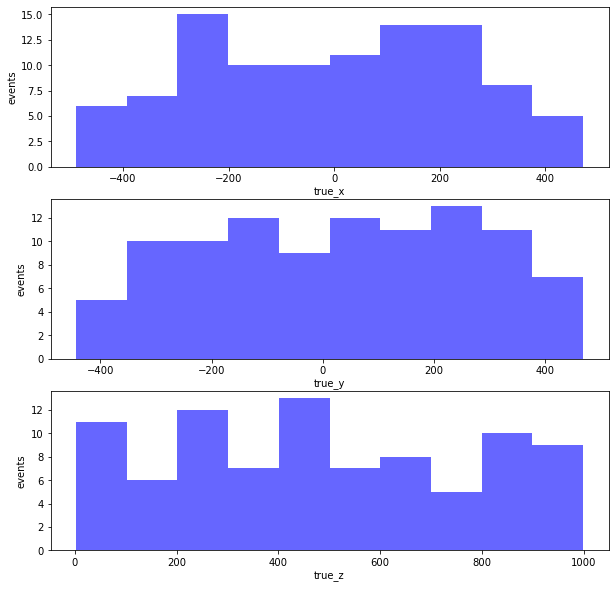

In [32]:
histos_df(evt_truePos, 
          vars    = ('true_x','true_y','true_z'), 
          varmins = [-500,-500,0], 
          varmaxs = [500,500,1000], 
          xlabels = ['true_x','true_y','true_z'], 
          ylabels = 3 * ['events'], 
          bins    = 3 * [10],
          alphas  = 3 * [0.6],
          colors  = 3 * ['b'],
          splt    = (3,1), 
          figsize = (10,10))

In [34]:
np.all(in_range(evt_truePos.true_x, -500, 500))

True

In [41]:
def test_get_evt_true_positions_df():

    xr = np.all(in_range(evt_truePos.true_x, -500, 500))
    yr = np.all(in_range(evt_truePos.true_y, -500, 500))
    zr = np.all(in_range(evt_truePos.true_z, 0, 1200))
    return xr and yr and zr


In [42]:
test_get_evt_true_positions_df()

True

***
def get_evt_true_positions_and_energy(mcParts: DataFrame)->DataFrame:
***

In [43]:
evt_truePosE = get_evt_true_positions_and_energy(mcParts)
evt_truePosE.head()

,true_x,true_y,true_z,KE
event_id,,,,
100000,411.851990,-83.967979,981.268127,41.543297
100001,-450.390076,-20.009449,848.892822,41.543297
100002,178.940918,-268.440735,295.103363,41.543297
100003,-36.024593,-41.193062,367.160645,41.543297
100004,176.177246,-167.092148,245.398712,41.543297


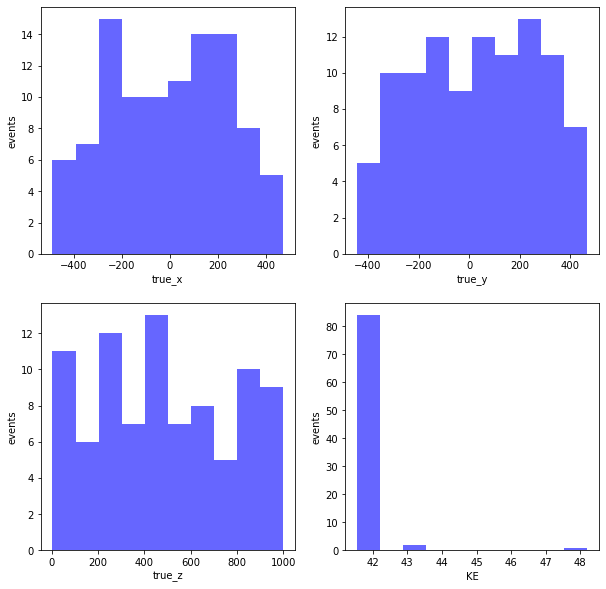

In [44]:
histos_df(evt_truePosE, 
          vars    = ('true_x','true_y','true_z','KE'), 
          varmins = [-500,-500,0, 40], 
          varmaxs = [500,500,1000, 50], 
          xlabels = ['true_x','true_y','true_z','KE'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (10,10))

In [52]:
np.all(in_range(evt_truePosE.KE, 40, 59))

True

### Functions that manipulate Sensors

In [54]:
get_sensor_binning(testFile)

,bin_width
sns_name,
PmtR11410,25.0
TP_SiPM,1000.0


In [55]:
get_sensor_binning(testFile2)

,bin_width
sns_name,
F_SENSOR_L,1000.0
F_SENSOR_R,1000.0
TP_SiPM,1000.0


In [56]:
sns_response = load_mcsensor_response_df(testFile)

In [57]:
sns_response.head()

charge      time
event_id sensor_id                  
100000   35              2  979100.0
         35              1  979175.0
         35              1  979275.0
         35              1  979400.0
         35              1  979525.0

***
def get_sensor_response(sns_response : DataFrame,
                        sensor_type  : str = 'PMT')->DataFrame:

***

#### PMTs

In [59]:
pmt_response = get_sensor_response(sns_response, sensor_type = 'PMT')

In [60]:
pmt_response.head()

charge      time
event_id sensor_id                  
100000   35              2  979100.0
         35              1  979175.0
         35              1  979275.0
         35              1  979400.0
         35              1  979525.0

In [61]:
np.all(in_range(pmt_response.index.get_level_values(1), 0, 60))

True

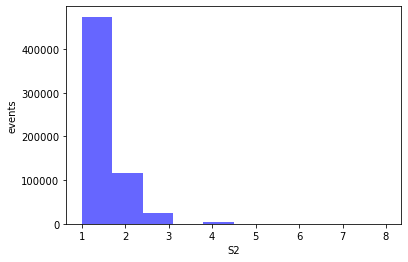

In [108]:
histo_df(pmt_response, 
         var = 'charge', 
         varmin = 0, 
         varmax = 10, 
         xlabel = 'S2', 
         ylabel = 'events',
         bins   = 10, 
         alpha  = 0.6, 
         color  = 'b')

In [107]:
np.all(in_range(pmt_response.charge, 0, 10))

True

#### Fibres

In [64]:
fibres_response = get_sensor_response(load_mcsensor_response_df(testFile2), sensor_type = 'FIBRES')
fibres_response.head()

charge       time
event_id sensor_id                   
100      100662          2  1005000.0
         100662          1  1007000.0
         100662          3  1008000.0
         100662          5  1009000.0
         100662          1  1010000.0

In [65]:
fibres_response.index.get_level_values(1)

UInt64Index([100662, 100662, 100662, 100662, 100662, 100662, 100662, 100662,
             100662, 100662,
             ...
             200347, 200347, 200347, 200347, 200347, 200347, 200347, 200347,
             200347, 200347],
            dtype='uint64', name='sensor_id', length=2052953)

In [66]:
np.all(in_range(fibres_response.index.get_level_values(1),100000,201545))

True

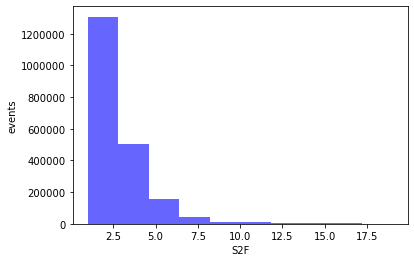

In [121]:
histo_df(fibres_response, 
         var = 'charge', 
         varmin = 0, 
         varmax = 20, 
         xlabel = 'S2F', 
         ylabel = 'events',
         bins   = 10, 
         alpha  = 0.6, 
         color  = 'b')

In [117]:
np.all(in_range(fibres_response.charge, 0, 200))

True

##### But notice that Fibres do not include tranmission or QE

#### SiPMs

In [67]:
sipm_response = get_sensor_response(sns_response, sensor_type = 'SIPM')

In [68]:
sipm_response.head()

charge      time
event_id sensor_id                  
100000   2137            2  980000.0
         2137            3  981000.0
         2137            2  982000.0
         2137            2  983000.0
         2137            3  984000.0

In [69]:
sipm_response.index.get_level_values(1)

UInt64Index([2137, 2137, 2137, 2137, 2137, 2137, 2137, 2137, 2137, 2137,
             ...
             1639, 1639, 1639, 1639, 1639, 1639, 1639, 1639, 1639, 2537],
            dtype='uint64', name='sensor_id', length=49727)

In [70]:
np.all(in_range(sipm_response.index.get_level_values(1),1000,4500))

True

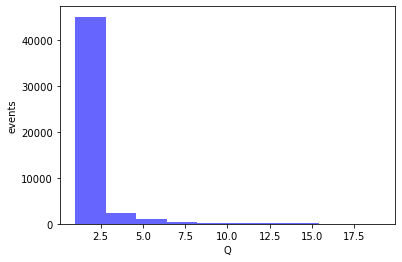

In [120]:
histo_df(sipm_response, 
         var = 'charge', 
         varmin = 0, 
         varmax = 20, 
         xlabel = 'Q', 
         ylabel = 'events',
         bins   = 10, 
         alpha  = 0.6, 
         color  = 'b')

In [122]:
np.all(in_range(sipm_response.charge, 0, 200))

True

***
def sensor_response_ti(sensor_response : DataFrame)->DataFrame:
***

#### PMTs 

In [72]:
pmtdf = sensor_response_ti(pmt_response)
pmtdf.head()

,event_id,sensor_id,tot_charge
0,100000,0,141
1,100000,1,128
2,100000,2,149
3,100000,3,148
4,100000,4,136


In [73]:
pmtdf["sensor_id"].values

array([ 0,  1,  2, ..., 57, 58, 59], dtype=uint64)

In [74]:
np.all(in_range(pmtdf.sensor_id, 0, 60))

True

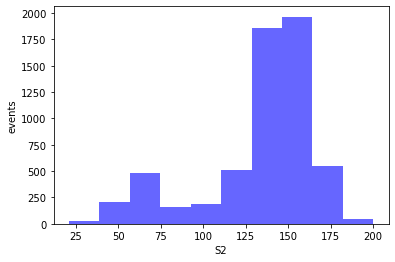

In [77]:
histo_df(pmtdf, 
         var = 'tot_charge', 
         varmin = 0, 
         varmax = 500, 
         xlabel = 'S2', 
         ylabel = 'events',
         bins   = 10, 
         alpha  = 0.6, 
         color  = 'b')

In [124]:
np.all(in_range(pmtdf.tot_charge, 0, 300))

True

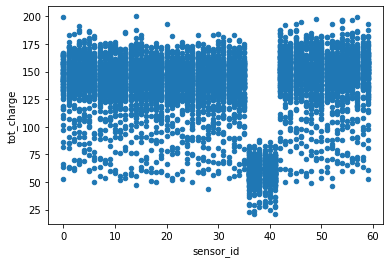

In [80]:
pmtdf.plot(kind='scatter', x='sensor_id', y='tot_charge')

In [90]:
pmt_10 = sensor_number_response_ti(pmt_response, sensor_id=10)

In [91]:
pmt_40 = sensor_number_response_ti(pmt_response, sensor_id=40)

In [99]:
pmt_10.head()

,event_id,sensor_id,tot_charge
10,100000,10,139
70,100001,10,125
130,100002,10,155
190,100003,10,135
250,100004,10,149


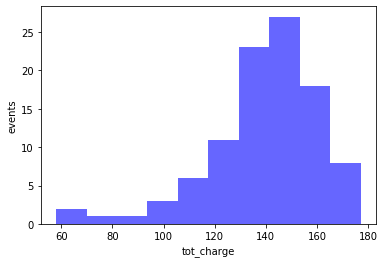

In [97]:
histo_df(pmt_10, 'tot_charge', 0, 200, 'tot_charge', 'events', 10, 0.6, 'b')

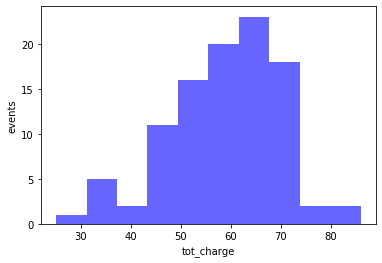

In [98]:
histo_df(pmt_40, 'tot_charge', 0, 200, 'tot_charge', 'events', 10, 0.6, 'b')

##### Why PMTs 35-45 see so much less charge than others?

#### SiPMs

In [81]:
sipmdf = sensor_response_ti(sipm_response)
sipmdf.head()

,event_id,sensor_id,tot_charge
0,100000,1008,1
1,100000,1013,1
2,100000,1032,1
3,100000,1034,1
4,100000,1035,1


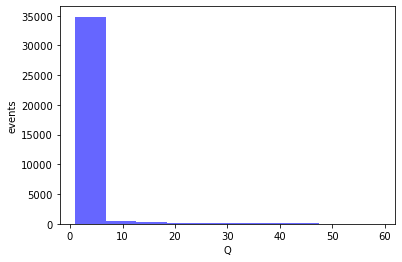

In [103]:
histo_df(sipmdf, 
         var = 'tot_charge', 
         varmin = 0, 
         varmax = 60, 
         xlabel = 'Q', 
         ylabel = 'events',
         bins   = 10, 
         alpha  = 0.6, 
         color  = 'b')

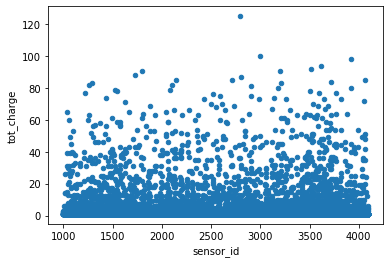

In [89]:
sipmdf.plot(kind='scatter', x='sensor_id', y='tot_charge')

In [128]:
np.all(in_range(sipmdf.tot_charge, 0, 130))

True

#### Fibres

In [129]:
fibdf = sensor_response_ti(fibres_response)
fibdf.head()

,event_id,sensor_id,tot_charge
0,100,100001,21
1,100,100002,22
2,100,100003,14
3,100,100004,12
4,100,100005,17


In [130]:
fibdf1 = fibdf[fibdf.sensor_id<200000]

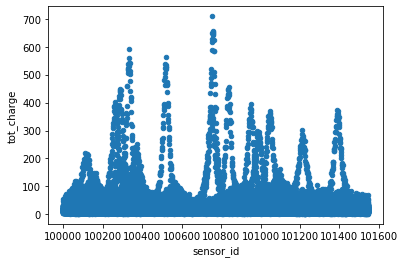

In [131]:
fibdf1.plot(kind='scatter', x='sensor_id', y='tot_charge')

In [132]:
fibdf2 = fibdf[fibdf.sensor_id>200000]

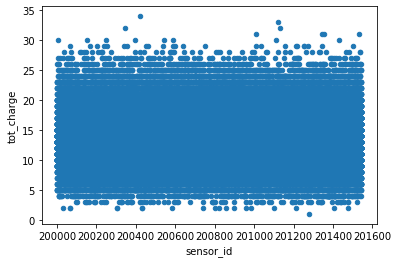

In [133]:
fibdf2.plot(kind='scatter', x='sensor_id', y='tot_charge')

##### Behaviour of fibres not consistent. Bug?

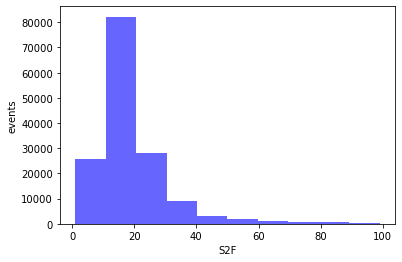

In [134]:
histo_df(fibdf1, 
         var = 'tot_charge', 
         varmin = 0, 
         varmax = 100, 
         xlabel = 'S2F', 
         ylabel = 'events',
         bins   = 10, 
         alpha  = 0.6, 
         color  = 'b')

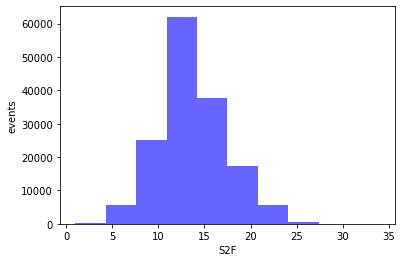

In [135]:
histo_df(fibdf2, 
         var = 'tot_charge', 
         varmin = 0, 
         varmax = 100, 
         xlabel = 'S2F', 
         ylabel = 'events',
         bins   = 10, 
         alpha  = 0.6, 
         color  = 'b')

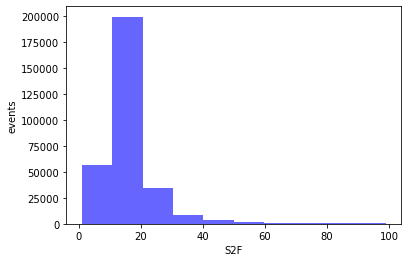

In [136]:
histo_df(fibdf, 
         var = 'tot_charge', 
         varmin = 0, 
         varmax = 100, 
         xlabel = 'S2F', 
         ylabel = 'events',
         bins   = 10, 
         alpha  = 0.6, 
         color  = 'b')

In [143]:
np.all(in_range(fibdf2.tot_charge, 0, 40))

True

***
def event_sensor_response_ti(sensor_response : DataFrame, event_id : int)->DataFrame:
***

#### PMTs

In [145]:
pmt_evt = event_sensor_response_ti(pmt_response, event_id=100000)

In [146]:
pmt_evt.head()

,event_id,sensor_id,tot_charge
0,100000,0,141
1,100000,1,128
2,100000,2,149
3,100000,3,148
4,100000,4,136


In [147]:
len(pmt_evt)

60

In [148]:
pmt_evt.tot_charge.sum()

7752

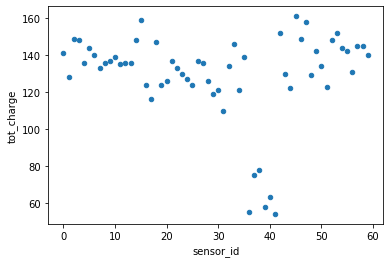

In [27]:
pmt_evt.plot(kind='scatter', x='sensor_id', y='tot_charge')

In [28]:
pmt_evt = event_sensor_response_ti(pmt_response, event_id=100099)

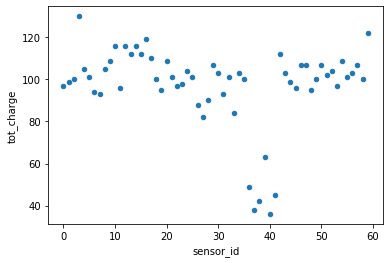

In [29]:
pmt_evt.plot(kind='scatter', x='sensor_id', y='tot_charge')

#### SiPMs 

In [149]:
sipm_evt = event_sensor_response_ti(sipm_response, event_id=100000)

In [150]:
sipm_evt.head()

,event_id,sensor_id,tot_charge
0,100000,1008,1
1,100000,1013,1
2,100000,1032,1
3,100000,1034,1
4,100000,1035,1


In [151]:
sipm_evt.tot_charge.sum()

795

#### Fibres

In [154]:
fib_evt = event_sensor_response_ti(fibres_response, event_id=100)

In [155]:
fib_evt.head()

,event_id,sensor_id,tot_charge
0,100,100001,21
1,100,100002,22
2,100,100003,14
3,100,100004,12
4,100,100005,17


In [156]:
fibevt1 = fib_evt[fib_evt.sensor_id<200000]
fibevt2 = fib_evt[fib_evt.sensor_id>200000]

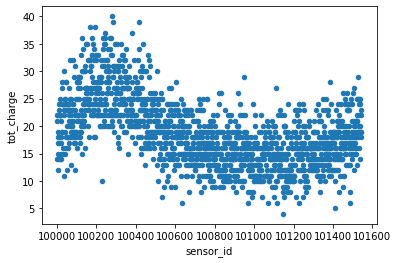

In [157]:
fibevt1.plot(kind='scatter', x='sensor_id', y='tot_charge')

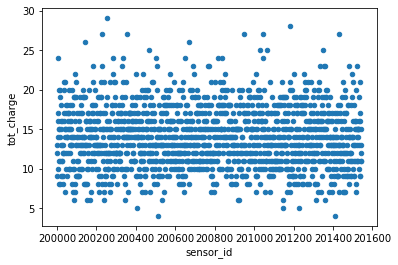

In [158]:
fibevt2.plot(kind='scatter', x='sensor_id', y='tot_charge')

In [159]:
fibevt1.tot_charge.sum()

28988

In [160]:
fibevt2.tot_charge.sum()

21648

In [161]:
fib_evt.tot_charge.sum()

50642

***
def mcparts_and_sensors_response(ifname : str,
                                 setup : Setup)->Union[Tuple[DataFrame],bool]:
***

In [131]:
result = mcparts_and_sensors_response(testFile, setup)

In [132]:
if result == False:
    pass
else:
    mcParts, energy_sensors_response, sipm_response = result

In [133]:
mcParts.head()

particle_name  primary  mother_id   initial_x  \
event_id particle_id                                                 
100000   2                      e-     True          0  411.851990   
         1                      e-     True          0  411.851990   
100001   2                      e-     True          0 -450.390076   
         1                      e-     True          0 -450.390076   
100002   2                      e-     True          0  178.940918   

                       initial_y   initial_z  initial_t     final_x  \
event_id particle_id                                                  
100000   2            -83.967979  981.268127        0.0  411.860229   
         1            -83.967979  981.268127        0.0  411.961487   
100001   2            -20.009449  848.892822        0.0 -450.372742   
         1            -20.009449  848.892822        0.0 -450.387573   
100002   2           -268.440735  295.103363        0.0  178.936234   

                         final_y     final_z  ...  initial_momentum_x  \
event_id particle_id                          ...                       
100000   2            -83.969376  981.265015  ...            0.024411   
         1            -84.069504  981.291992  ...           -0.111088   
100001   2            -19.999857  848.884277  ...            0.061492   
         1            -19.987989  848.998352  ...            0.032593   
100002   2           -268.445679  295.094177  ...           -0.088341   

                     initial_momentum_y initial_momentum_z  final_momentum_x  \
event_id particle_id                                                           
100000   2                     0.014236           0.094300               0.0   
         1                    -0.118718           0.086334              -0.0   
100001   2                     0.060949          -0.046850               0.0   
         1                     0.113901           0.140898               0.0   
100002   2                    -0.030742          -0.030689              -0.0   

                      final_momentum_y  final_momentum_z  kin_energy  \
event_id particle_id                                                   
100000   2                         0.0              -0.0    0.009396   
         1                        -0.0               0.0    0.032147   
100001   2                         0.0               0.0    0.009396   
         1                        -0.0              -0.0    0.032147   
100002   2                         0.0               0.0    0.009396   

                        length  creator_proc     final_proc  
event_id particle_id                                         
100000   2            0.062259          none  Scintillation  
         1            0.456158          none  Scintillation  
100001   2            0.066419          none  Scintillation  
         1            0.569584          none  Scintillation  
100002   2            0.076495          none  Scintillation  

[5 rows x 23 columns]

In [134]:
energy_sensors_response.head()

charge      time
event_id sensor_id                  
100000   35              2  979100.0
         35              1  979175.0
         35              1  979275.0
         35              1  979400.0
         35              1  979525.0

In [135]:
sipm_response.head()

charge      time
event_id sensor_id                  
100000   2137            2  980000.0
         2137            3  981000.0
         2137            2  982000.0
         2137            2  983000.0
         2137            3  984000.0

***
def get_s1(energy_sensors_response : DataFrame)->Series:
***

In [162]:
s1 = get_s1(pmt_response)

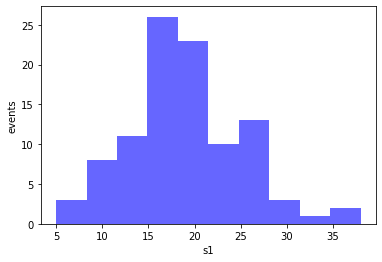

In [163]:
histo1d(s1.values, 0, 100, "s1", "events",
        bins=10, alpha=0.6, color='b')

In [164]:
np.all(in_range(s1, 5, 45))

True

***
def get_s2(energy_sensors_response : DataFrame)->Series:
***

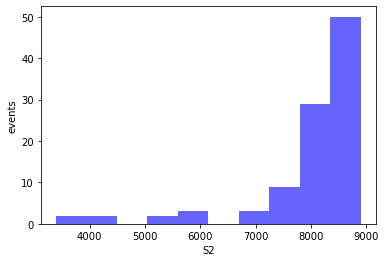

In [165]:
s2 = get_s2(pmt_response)
histo1d(s2.values, 0, 10000, "S2", "events",
        bins=10, alpha=0.6, color='b')

In [166]:
np.all(in_range(s2, 3000, 9000))

True

***
def get_qtot(sipmdf: DataFrame, setup : Setup)->Series:
***

In [168]:
qtot = get_qtot(sipmdf, setup)

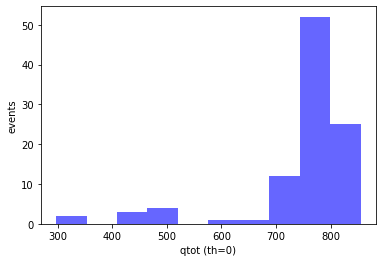

In [169]:
histo1d(qtot.values, 0, 1000, "qtot (th=0)", "events",
        bins=10, alpha=0.6, color='b')

In [170]:
np.all(in_range(qtot, 200, 900))

True

##### Effect of a threshold

In [171]:
setup5 = Setup(qTh=5)

In [172]:
qtot5 = get_qtot(sipmdf, setup5)

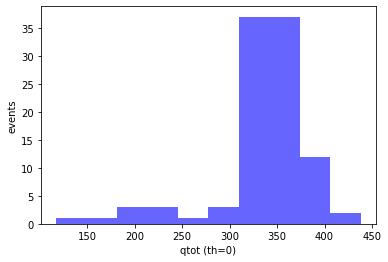

In [173]:
histo1d(qtot5.values, 0, 1000, "qtot (th=0)", "events",
        bins=10, alpha=0.6, color='b')

##### NB: total charge changes dramatically with cutoff. Should not be used for baricenter

***
def get_q(sipmevt : DataFrame, ix : int, setup : Setup)->float:
***

In [178]:
Q = [get_q(sipm_evt, ix, setup) for ix in sipm_evt['sensor_id'].values]

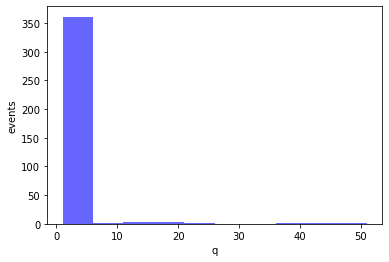

In [181]:
histo1d(Q, 0, 10, "q", "events",
        bins=10, alpha=0.6, color='b')

***
def get_position(event_list :List,
                 sipmdf     : DataFrame,
                 sipm_map   : DataFrame,
                 ic: int = 1000)->PosQ:
                 
    """Computes the (x,y) position of the event:
    digital algorithm: - position of the SiPM with max charge
    analog  algorithm: baricenter using (l,r) and (u,p) of qmax

    """
***

In [183]:
krdf = evt_truePosE

In [250]:
pq = get_position(krdf.index, sipmdf, sipm_map, setup, ic=50)

 event = 0 event number = 100000
 event = 50 event number = 100050


In [251]:
pq

,xMax,yMax,xPos,yPos,rPos,qMax,qL,qR,qU,qD
event_id,,,,,,,,,,
100000,419.85,-77.75,416.439916,-81.071359,497.511275,51.0,44.0,19.0,15.0,37.0
100001,-450.95,-15.55,-450.279748,-18.414474,468.694222,51.0,30.0,35.0,21.0,42.0
100002,171.05,-264.35,175.551317,-266.793574,442.344891,78.0,15.0,59.0,20.0,42.0
100003,-31.10,-46.65,-34.862097,-44.058334,78.920431,54.0,50.0,20.0,50.0,28.0
100004,171.05,-171.05,173.886826,-166.951552,340.838378,69.0,26.0,53.0,47.0,13.0
...,...,...,...,...,...,...,...,...,...,...
100095,-77.75,-295.45,-80.365888,-291.962156,372.328044,51.0,37.0,19.0,40.0,16.0
100096,-124.40,466.50,-125.854972,461.964583,587.819555,85.0,51.0,35.0,0.0,35.0
100097,93.30,-419.85,94.177824,-422.644144,516.821969,53.0,32.0,39.0,26.0,49.0


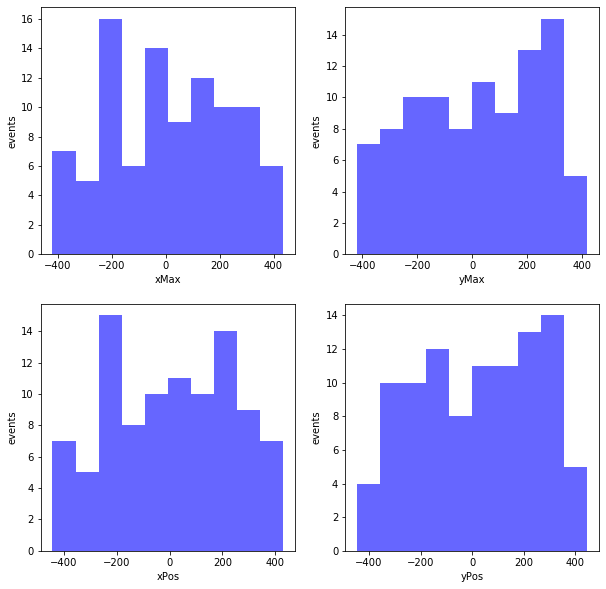

In [252]:
histos_df(pq, 
          vars    = ('xMax','yMax','xPos','yPos'), 
          varmins = 4 * [-450], 
          varmaxs = 4 * [450], 
          xlabels = ['xMax','yMax','xPos','yPos'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (10,10))

In [253]:
print(np.all(in_range(pq.xMax, -500, 500)))
print(np.all(in_range(pq.yMax, -500, 500)))
print(np.all(in_range(pq.xPos, -500, 500)))
print(np.all(in_range(pq.yPos, -500, 500)))

True
True
True
True


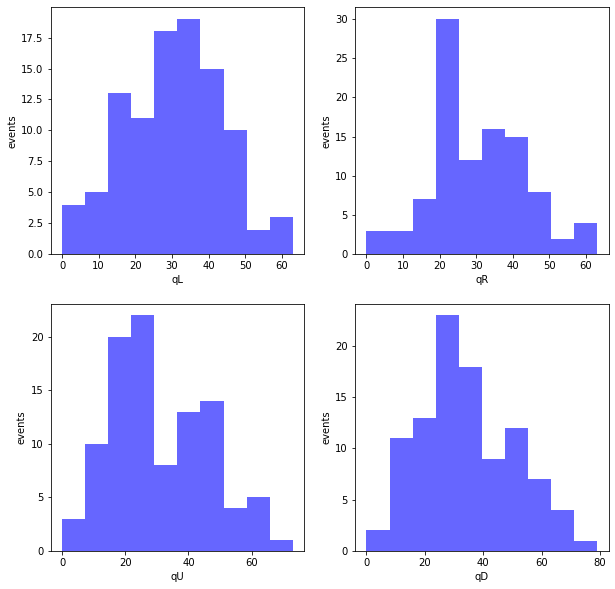

In [255]:
histos_df(pq, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [100], 
          xlabels = ['qL','qR','qU','qD'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (10,10))

In [256]:
qmax = 100
print(np.all(in_range(pq.qL, 0, qmax)))
print(np.all(in_range(pq.qR, 0, qmax)))
print(np.all(in_range(pq.qU, 0, qmax)))
print(np.all(in_range(pq.qD, 0, qmax)))

True
True
True
True


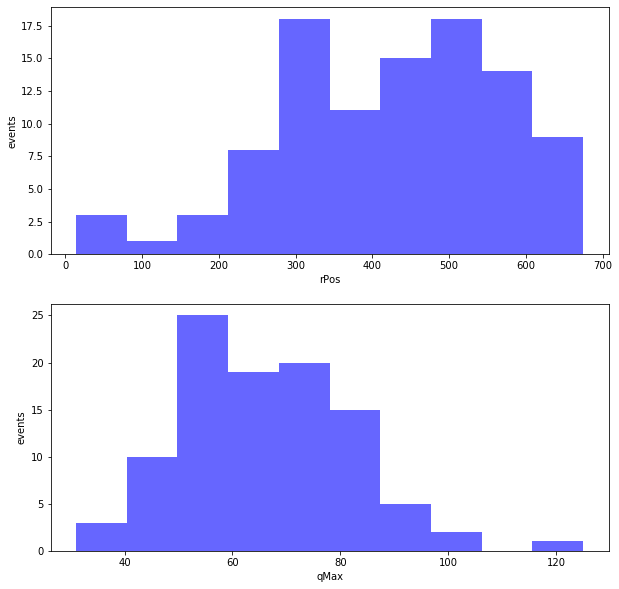

In [257]:
histos_df(pq, 
          vars    = ('rPos','qMax'), 
          varmins = [0,0], 
          varmaxs = [1000,200], 
          xlabels = ['rPos','qMax'], 
          ylabels = 2 * ['events'], 
          bins    = 2 * [10],
          alphas  = 2 * [0.6],
          colors  = 2 * ['b'],
          splt    = (2,1), 
          figsize = (10,10))

In [258]:
print(np.all(in_range(pq.rPos, 0, 700)))
print(np.all(in_range(pq.qMax, 0, 200)))

True
True


***
def diff_pos(truedf : DataFrame, pqdf : DataFrame)->DataFrame:

    """
    Compute the difference between true and estimated positions
    truedf is the data frame with true positions
    posdf  is the data frame with estimated positions

    """
***

In [261]:
dxdf = diff_pos(krdf, pq)

In [262]:
dxdf

,dxPos,dyPos,dxMax,dyMax
event_id,,,,
100000,-4.587926,-2.896620,-7.998010,-6.217979
100001,-0.110327,-1.594975,0.559924,-4.459449
100002,3.389601,-1.647161,7.890918,-4.090735
100003,-1.162496,2.865272,-4.924593,5.456938
100004,2.290420,-0.140596,5.127246,3.957852
...,...,...,...,...
100095,-0.658763,2.951017,-3.274651,6.438861
100096,-1.144288,5.992234,-2.599260,1.456818
100097,1.567087,-1.662344,2.444911,-4.456488


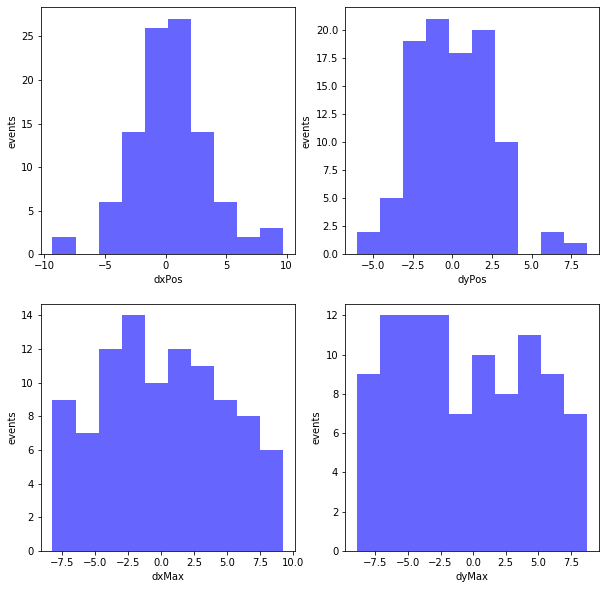

In [263]:
histos_df(dxdf, 
          vars    = ('dxPos','dyPos','dxMax','dyMax'), 
          varmins = 4 * [-10], 
          varmaxs = 4 * [10], 
          xlabels = ['dxPos','dyPos','dxMax','dyMax'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (10,10))

In [265]:
qmax = 20
print(np.all(in_range(dxdf.dxPos, -qmax, qmax)))
print(np.all(in_range(dxdf.dyPos, -qmax, qmax)))
print(np.all(in_range(dxdf.dxMax, -qmax, qmax)))
print(np.all(in_range(dxdf.dyMax, -qmax, qmax)))

True
True
True
True


### Merge dsts

In [211]:
krdf.head()

,true_x,true_y,true_z,KE
event_id,,,,
100000,411.851990,-83.967979,981.268127,41.543297
100001,-450.390076,-20.009449,848.892822,41.543297
100002,178.940918,-268.440735,295.103363,41.543297
100003,-36.024593,-41.193062,367.160645,41.543297
100004,176.177246,-167.092148,245.398712,41.543297


In [247]:
dxdf.head()

,dxPos,dyPos,dxMax,dyMax
event_id,,,,
100000,-4.587926,-2.896620,-7.998010,-6.217979
100001,-0.110327,-1.594975,0.559924,-4.459449
100002,3.389601,-1.647161,7.890918,-4.090735
100003,-1.162496,2.865272,-4.924593,5.456938
100004,2.290420,-0.140596,5.127246,3.957852


In [266]:
pq.head()

,xMax,yMax,xPos,yPos,rPos,qMax,qL,qR,qU,qD
event_id,,,,,,,,,,
100000,419.85,-77.75,416.439916,-81.071359,497.511275,51.0,44.0,19.0,15.0,37.0
100001,-450.95,-15.55,-450.279748,-18.414474,468.694222,51.0,30.0,35.0,21.0,42.0
100002,171.05,-264.35,175.551317,-266.793574,442.344891,78.0,15.0,59.0,20.0,42.0
100003,-31.10,-46.65,-34.862097,-44.058334,78.920431,54.0,50.0,20.0,50.0,28.0
100004,171.05,-171.05,173.886826,-166.951552,340.838378,69.0,26.0,53.0,47.0,13.0


In [269]:
krdst = pd.concat([krdf, pq, dxdf], axis=1)

In [270]:
krdst

,true_x,true_y,true_z,KE,xMax,yMax,xPos,yPos,rPos,qMax,qL,qR,qU,qD,dxPos,dyPos,dxMax,dyMax
event_id,,,,,,,,,,,,,,,,,,
100000,411.851990,-83.967979,981.268127,41.543297,419.85,-77.75,416.439916,-81.071359,497.511275,51.0,44.0,19.0,15.0,37.0,-4.587926,-2.896620,-7.998010,-6.217979
100001,-450.390076,-20.009449,848.892822,41.543297,-450.95,-15.55,-450.279748,-18.414474,468.694222,51.0,30.0,35.0,21.0,42.0,-0.110327,-1.594975,0.559924,-4.459449
100002,178.940918,-268.440735,295.103363,41.543297,171.05,-264.35,175.551317,-266.793574,442.344891,78.0,15.0,59.0,20.0,42.0,3.389601,-1.647161,7.890918,-4.090735
100003,-36.024593,-41.193062,367.160645,41.543297,-31.10,-46.65,-34.862097,-44.058334,78.920431,54.0,50.0,20.0,50.0,28.0,-1.162496,2.865272,-4.924593,5.456938
100004,176.177246,-167.092148,245.398712,41.543297,171.05,-171.05,173.886826,-166.951552,340.838378,69.0,26.0,53.0,47.0,13.0,2.290420,-0.140596,5.127246,3.957852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100095,-81.024651,-289.011139,1110.113770,41.543297,-77.75,-295.45,-80.365888,-291.962156,372.328044,51.0,37.0,19.0,40.0,16.0,-0.658763,2.951017,-3.274651,6.438861
100096,-126.999260,467.956818,471.085388,41.543297,-124.40,466.50,-125.854972,461.964583,587.819555,85.0,51.0,35.0,0.0,35.0,-1.144288,5.992234,-2.599260,1.456818
100097,95.744911,-424.306488,883.392212,41.543297,93.30,-419.85,94.177824,-422.644144,516.821969,53.0,32.0,39.0,26.0,49.0,1.567087,-1.662344,2.444911,-4.456488


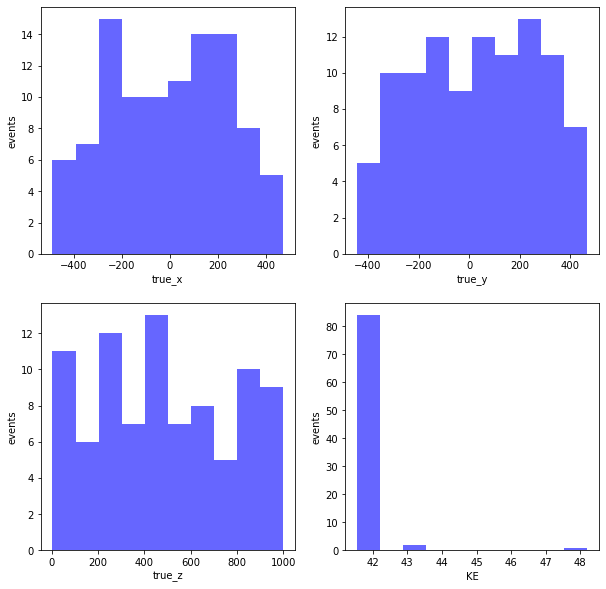

In [273]:
histos_df(krdst, 
          vars    = ('true_x','true_y','true_z','KE'), 
          varmins = [-500,-500,0, 40], 
          varmaxs = [500,500,1000, 50], 
          xlabels = ['true_x','true_y','true_z','KE'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (10,10))

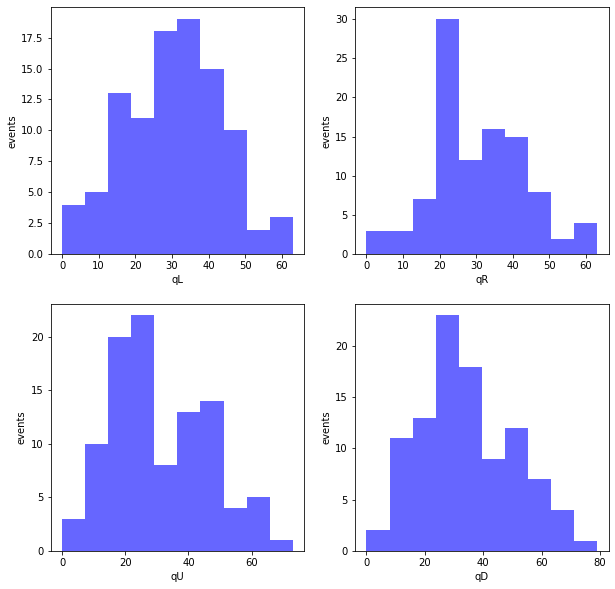

In [271]:
histos_df(krdst, 
          vars    = ('qL','qR','qU','qD'), 
          varmins = 4 * [0], 
          varmaxs = 4 * [100], 
          xlabels = ['qL','qR','qU','qD'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (10,10))

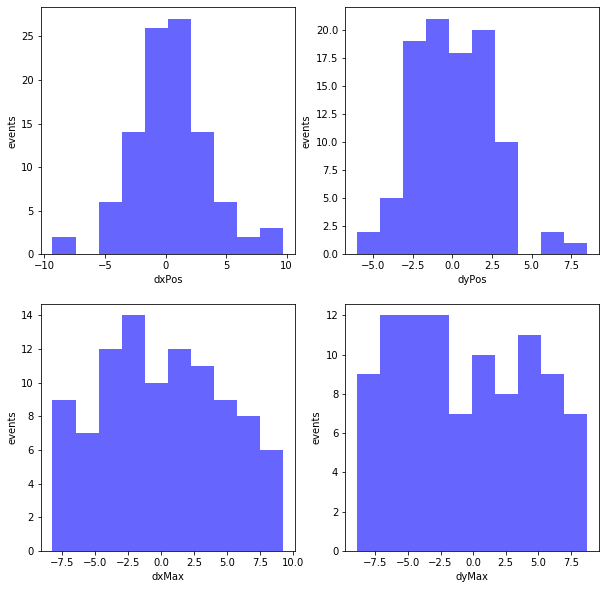

In [272]:
histos_df(krdst, 
          vars    = ('dxPos','dyPos','dxMax','dyMax'), 
          varmins = 4 * [-10], 
          varmaxs = 4 * [10], 
          xlabels = ['dxPos','dyPos','dxMax','dyMax'], 
          ylabels = 4 * ['events'], 
          bins    = 4 * [10],
          alphas  = 4 * [0.6],
          colors  = 4 * ['b'],
          splt    = (2,2), 
          figsize = (10,10))

In [274]:
len(krdst.index)

100

## kr_dst

### Extract dst 

In [277]:
ifnames = [testFile]
gf, bf = kr_dst(ifnames, sipm_map, setup, ic=50)
print(f'good files ={gf}')
print(f'bad files ={bf}')


reading file /Users/jj/Development/flexdata/testData/FLEX100_M6_O6.Kr83.ACTIVE.1000.next.h5
 event = 0 event number = 100000
 event = 50 event number = 100050
saving file /Users/jj/Development/flexdata/testData/FLEX100_M6_O6Kr83.ACTIVE.1000.next.csv, with 100 events
good files =['/Users/jj/Development/flexdata/testData/FLEX100_M6_O6.Kr83.ACTIVE.1000.next.h5']
bad files =[]


In [278]:
setup

Setup(name='NEXT100_PMTs_sipmPDE_1_maskPDE_1_qTh_0', sipmPDE=1.0, maskPDE=1.0, qTh=0.0, maskConfig='FLEX100_M6_O6', mapDIR='flexmaps', fibres=False)